In [2]:
import os
import sys
import warnings

os.chdir("../..")
sys.path.append("../../")
warnings.filterwarnings("ignore")

# Benchmarking methods for identification of DE genes along continuous trajectory

## Introduction

In this example, we will demonstrate how to use scDesign3Py to generate negative control and benchmark methods for identifying differentially expressed (DE) genes along continuous trajectory from scRNA-seq data. Please note that here we only did a very brief benchmarking for illustration purpose, not for formal comparison.

## Import packages and Read in data

### import pacakges

In [3]:
import anndata as ad
import numpy as np
import pandas as pd
import scDesign3Py

The R project used is located at /home/ld/mambaforge/envs/cell2loc/lib/R


### Read in data

The raw data is from the [scvelo](https://scvelo.readthedocs.io/scvelo.datasets.pancreas/), which describes pancreatic endocrinogenesis, and is converted to `.h5ad` file using the R package `sceasy`. We pre-select the top 1000 highly variable genes and filter out some cell types to ensure a **single trajectory**.

To save computational time, we only use the top 200 genes.

In [4]:
data = ad.read_h5ad("data/PANCREAS.h5ad")
data = data[:,:200]
data

View of AnnData object with n_obs × n_vars = 2087 × 200
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'cell_type', 'sizeFactor', 'pseudotime'
    var: 'highly_variable_genes'
    obsm: 'X_pca', 'X_umap', 'X_x_pca', 'X_x_umap'

## Simulation

We use the step-by-step functions instead of the one-shot function to generate synthetic data since these step-by-step functions allow us to alter estimated parameters and generate new data based on our desired parameters.

In [5]:
example = scDesign3Py.scDesign3(n_cores=3,parallelization="pbmcmapply")

In [6]:
example_data = example.construct_data(    
    anndata = data,
    default_assay_name = "counts",
    celltype = "cell_type",
    pseudotime="pseudotime",
    corr_formula = "1")

In [7]:
example.set_r_random_seed(123)
example_marginal = example.fit_marginal(
    mu_formula = "s(pseudotime, k = 10, bs = 'cr')",
    sigma_formula = "1",
    family_use = "nb",
    usebam = False
)

  |                                                              |   0%, ETA NA

  |=======================================================| 100%, Elapsed 00:29


In [8]:
example.set_r_random_seed(123)
example_copula = example.fit_copula()

R[write to console]: Convert Residuals to Multivariate Gaussian



  |=======================================================| 100%, Elapsed 00:13


R[write to console]: Converting End

R[write to console]: Copula group 1 starts



In [9]:
example_para = example.extract_para()

  |=                                                          |   1%, ETA 00:21

  |=======================================================| 100%, Elapsed 00:10


Here, we examine the `mean_mat`, which is one of the outputs from the previous function `extract_para()`. For each gene, we calculate the difference in the between the maximum mean parameter and minimum mean parameter across all cells. We select genes which the gene’s mean difference across cells are in the top 50 largest differences. We regard these genes as DE genes. Then, we manually set the mean parameters of the rest genes to be the same across all cells. We regard all genes with the same mean parameter across cells as non-DE genes. Of course, this is a very flexible step and users may choose other ideas to modify the mean matrix.

In [10]:
diff_idx = (example_para["mean_mat"].max() - example_para["mean_mat"].min()).sort_values(ascending=False).index
de_idx = diff_idx[:50]
no_de_idx = diff_idx[50:]
example_para["mean_mat"][no_de_idx] = ((example_para["mean_mat"].max() + example_para["mean_mat"].min())/2)[no_de_idx]

In [11]:
example.set_r_random_seed(123)
example_newcount = example.simu_new(mean_mat=example_para["mean_mat"])

R[write to console]: Use Copula to sample a multivariate quantile matrix

R[write to console]: Sample Copula group 1 starts



  |=======================================================| 100%, Elapsed 00:01


## DE genes identification

Now, we use the simulated data to benchmark the performance of [scFates](https://scfates.readthedocs.io), a DEG identification method as an example.

In [23]:
simu_data = ad.AnnData(X=example_newcount, obs=example_data["newCovariate"])
simu_data.layers["log_transformed"] = np.log1p(simu_data.X)
simu_data.obs["t"] = simu_data.obs["pseudotime"]
simu_data.obs["seg"] = 1

In [15]:
import scFates as scf

In [13]:
qvals = pd.DataFrame(index=simu_data.var_names)
methods = ["scFates"]

In [27]:
scf.tl.test_association(simu_data)

test features for association with the trajectory
    single mapping :   0%|          | 0/200 [00:00<?, ?it/s]

    single mapping : 100%|██████████| 200/200 [01:01<00:00,  3.24it/s]
    found 50 significant features (0:01:01) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


In [28]:
qvals["scFates"] = simu_data.var["fdr"]

Since we manually created non-DE genes in the `extra_para()` step, now we can calculate the actual false discovery proportion(FDP) and power of the DE tests we conducted above with various target FDR threshold.

In [29]:
targetFDR = np.concatenate([np.arange(0.01,0.11,0.01),np.arange(0.2,0.6,0.1)])
fdp = pd.DataFrame(index=targetFDR,columns=methods)
power = pd.DataFrame(index=targetFDR,columns=methods)

for method in methods:
    curr_p = qvals[method]
    for threshold in targetFDR:
        discovery = curr_p[curr_p <= threshold]
        true_positive = discovery.index.intersection(de_idx).shape[0]

        if len(discovery) == 0:
            fdp.loc[threshold,method] = 0
        else:
            fdp.loc[threshold,method] = (len(discovery) - true_positive)/len(discovery)
        
        power.loc[threshold,method] = true_positive/de_idx.shape[0]

## Visualization

We visualize the Target FDR vs Actual FDP and Target FDR vs Power below.

In [30]:
import matplotlib.pyplot as plt

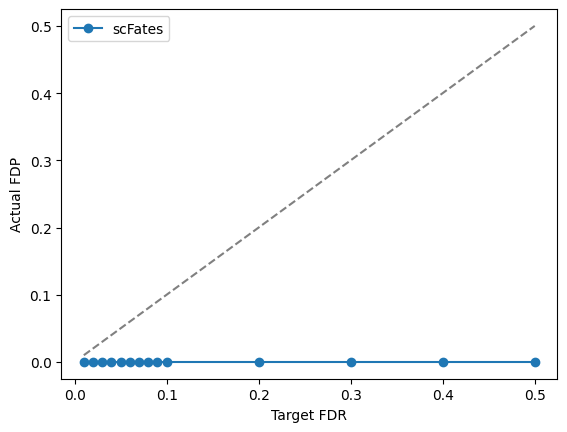

In [31]:
for method in methods:
    plt.plot(targetFDR,fdp[method],"o-",label=method)

plt.plot(targetFDR, targetFDR, '--', color='gray')
plt.xlabel('Target FDR')
plt.ylabel('Actual FDP')
plt.legend(loc="best")
plt.show()

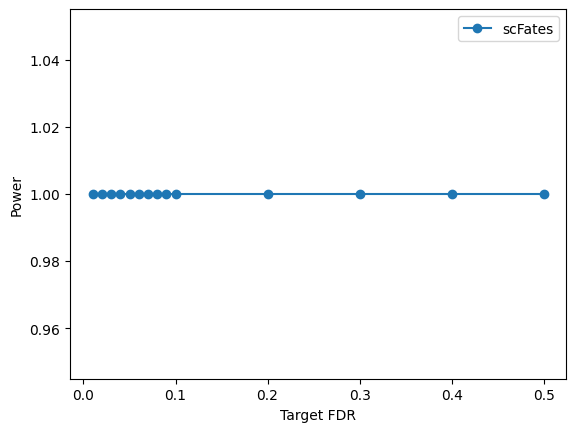

In [32]:
for method in methods:
    plt.plot(targetFDR,power[method],"o-",label=method)

plt.xlabel('Target FDR')
plt.ylabel('Power')
plt.legend(loc="best")
plt.show()